classification without pretrain 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import random

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
version = "v10-3c"

OUTPUT_DIR = '/root/' + version + '/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

In [6]:
class CFG:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    batch_size = 256

In [7]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.CIFAR10(root='/root/', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='/root/', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=CFG.batch_size, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = CFG.batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [9]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

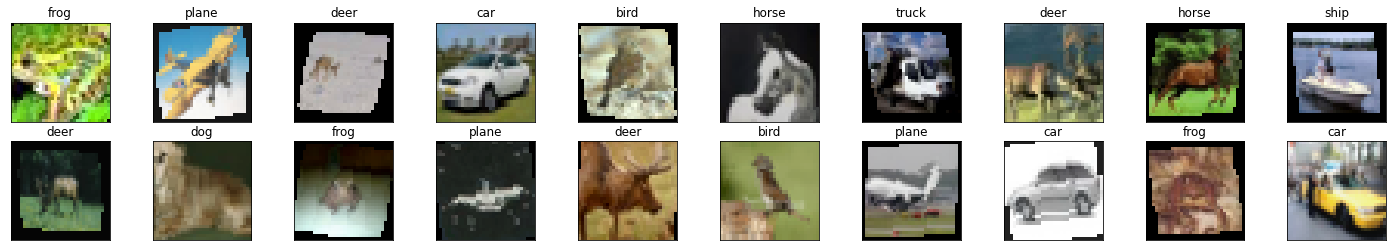

In [10]:
# We iter the batch of images to display
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [11]:
import hydra
from omegaconf import DictConfig
import logging

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34
from torchvision import transforms
from tqdm import tqdm
import glob

class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))
        self.fc1 = nn.Linear(projection_dim, 10)

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return self.fc1(projection)

    

In [12]:
import torch
model = SimCLR(eval('resnet18'), projection_dim=128)
# model.load_state_dict(
#         torch.load("v10-5/simclr_resnet18.pt", map_location="cpu"), strict = False
#     )
model.to(CFG.device) # run our model on cuda GPU for faster results
print("")

In [13]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # fine tuned the lr

In [14]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
LOGGER.info('Step,Train Loss,Train Auc,Valid Loss,Valid Auc')
for e in range(epochs): # training our model, put input according to every batch.
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    train_num = 0
    val_num = 0

    tqdm_bar = tqdm(training_loader, desc=f'Training Epoch {e} ', total=int(len(training_loader)))
    for i, (inputs, labels) in enumerate(tqdm_bar):
        inputs = inputs.to(CFG.device) # input to device as our model is running in mentioned device.
        labels = labels.to(CFG.device)
        
        model.train()
        outputs = model(inputs) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
        
        train_num += len(preds)
        
        tqdm_bar.set_postfix(train_loss=running_loss/(i+1), train_accuracy=running_corrects.item()/(train_num))
    else:
        with torch.no_grad(): # we do not need gradient for validation.
            tqdm_bar = tqdm(validation_loader, desc=f'Validation Epoch {e} ', total=int(len(validation_loader)))
            for i, (val_inputs, val_labels) in enumerate(tqdm_bar):
                val_inputs = val_inputs.to(CFG.device)
                val_labels = val_labels.to(CFG.device)
                
                #t = torch.randint(0, 4000, (len(val_labels),), device=dist_util.dev()).long()
                model.eval()
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
                val_num += len(val_preds)
                
                tqdm_bar.set_postfix(val_loss=val_running_loss/(i+1), val_accuracy=val_running_corrects.item()/(val_num))
      
        epoch_loss = running_loss/len(training_loader) # loss per epoch
        epoch_acc = running_corrects.float()/ train_num # accuracy per epoch
        running_loss_history.append(epoch_loss) # appending for displaying 
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ val_num
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        # LOGGER.info('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        # LOGGER.info('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        LOGGER.info('{:d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format((e+1) * len(training_loader), epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

Step,Train Loss,Train Auc,Valid Loss,Valid Auc
Validation Epoch 0 : 100%|██████████| 40/40 [00:03<00:00, 11.98it/s, val_accuracy=0.431, val_loss=1.49]
196, 1.8193, 0.3093, 1.4906, 0.4309


epoch : 1
training loss: 1.8193, acc 0.3093 
validation loss: 1.4906, validation acc 0.4309 


Validation Epoch 1 : 100%|██████████| 40/40 [00:02<00:00, 16.53it/s, val_accuracy=0.497, val_loss=1.34]
392, 1.3682, 0.4948, 1.3428, 0.4967


epoch : 2
training loss: 1.3682, acc 0.4948 
validation loss: 1.3428, validation acc 0.4967 


Validation Epoch 2 : 100%|██████████| 40/40 [00:03<00:00, 11.73it/s, val_accuracy=0.629, val_loss=1.02]
588, 1.1428, 0.5843, 1.0229, 0.6292


epoch : 3
training loss: 1.1428, acc 0.5843 
validation loss: 1.0229, validation acc 0.6292 


Validation Epoch 3 : 100%|██████████| 40/40 [00:03<00:00, 13.06it/s, val_accuracy=0.641, val_loss=1.02]
784, 0.9957, 0.6434, 1.0161, 0.6415


epoch : 4
training loss: 0.9957, acc 0.6434 
validation loss: 1.0161, validation acc 0.6415 


Validation Epoch 4 : 100%|██████████| 40/40 [00:02<00:00, 13.69it/s, val_accuracy=0.734, val_loss=0.758]
980, 0.8776, 0.6862, 0.7581, 0.7340


epoch : 5
training loss: 0.8776, acc 0.6862 
validation loss: 0.7581, validation acc 0.7340 


Validation Epoch 5 : 100%|██████████| 40/40 [00:03<00:00, 12.96it/s, val_accuracy=0.753, val_loss=0.706]
1176, 0.7829, 0.7249, 0.7055, 0.7528


epoch : 6
training loss: 0.7829, acc 0.7249 
validation loss: 0.7055, validation acc 0.7528 


Validation Epoch 6 : 100%|██████████| 40/40 [00:03<00:00, 13.06it/s, val_accuracy=0.779, val_loss=0.651]
1372, 0.7066, 0.7513, 0.6507, 0.7789


epoch : 7
training loss: 0.7066, acc 0.7513 
validation loss: 0.6507, validation acc 0.7789 


Validation Epoch 7 : 100%|██████████| 40/40 [00:02<00:00, 13.39it/s, val_accuracy=0.796, val_loss=0.61] 
1568, 0.6394, 0.7770, 0.6103, 0.7965


epoch : 8
training loss: 0.6394, acc 0.7770 
validation loss: 0.6103, validation acc 0.7965 


Validation Epoch 8 : 100%|██████████| 40/40 [00:03<00:00, 13.18it/s, val_accuracy=0.819, val_loss=0.525]
1764, 0.5892, 0.7945, 0.5252, 0.8191


epoch : 9
training loss: 0.5892, acc 0.7945 
validation loss: 0.5252, validation acc 0.8191 


Validation Epoch 9 : 100%|██████████| 40/40 [00:02<00:00, 13.53it/s, val_accuracy=0.832, val_loss=0.494]
1960, 0.5383, 0.8148, 0.4944, 0.8319


epoch : 10
training loss: 0.5383, acc 0.8148 
validation loss: 0.4944, validation acc 0.8319 


Validation Epoch 10 : 100%|██████████| 40/40 [00:02<00:00, 14.47it/s, val_accuracy=0.828, val_loss=0.51] 
2156, 0.5035, 0.8232, 0.5099, 0.8280


epoch : 11
training loss: 0.5035, acc 0.8232 
validation loss: 0.5099, validation acc 0.8280 


Validation Epoch 11 : 100%|██████████| 40/40 [00:02<00:00, 13.50it/s, val_accuracy=0.848, val_loss=0.449]
2352, 0.4687, 0.8364, 0.4486, 0.8475


epoch : 12
training loss: 0.4687, acc 0.8364 
validation loss: 0.4486, validation acc 0.8475 


Validation Epoch 12 : 100%|██████████| 40/40 [00:03<00:00, 13.29it/s, val_accuracy=0.819, val_loss=0.557]
2548, 0.4451, 0.8473, 0.5568, 0.8194


epoch : 13
training loss: 0.4451, acc 0.8473 
validation loss: 0.5568, validation acc 0.8194 


Validation Epoch 13 : 100%|██████████| 40/40 [00:02<00:00, 16.45it/s, val_accuracy=0.845, val_loss=0.463]
2744, 0.4194, 0.8549, 0.4632, 0.8451


epoch : 14
training loss: 0.4194, acc 0.8549 
validation loss: 0.4632, validation acc 0.8451 


Validation Epoch 14 : 100%|██████████| 40/40 [00:03<00:00, 12.99it/s, val_accuracy=0.851, val_loss=0.435]
2940, 0.3918, 0.8648, 0.4346, 0.8514


epoch : 15
training loss: 0.3918, acc 0.8648 
validation loss: 0.4346, validation acc 0.8514 


Validation Epoch 15 : 100%|██████████| 40/40 [00:03<00:00, 12.60it/s, val_accuracy=0.865, val_loss=0.403]
3136, 0.3747, 0.8687, 0.4033, 0.8649


epoch : 16
training loss: 0.3747, acc 0.8687 
validation loss: 0.4033, validation acc 0.8649 


Validation Epoch 16 : 100%|██████████| 40/40 [00:03<00:00, 13.15it/s, val_accuracy=0.871, val_loss=0.392]
3332, 0.3487, 0.8775, 0.3924, 0.8710


epoch : 17
training loss: 0.3487, acc 0.8775 
validation loss: 0.3924, validation acc 0.8710 


Validation Epoch 17 : 100%|██████████| 40/40 [00:03<00:00, 13.19it/s, val_accuracy=0.876, val_loss=0.381]
3528, 0.3330, 0.8836, 0.3814, 0.8760


epoch : 18
training loss: 0.3330, acc 0.8836 
validation loss: 0.3814, validation acc 0.8760 


Validation Epoch 18 : 100%|██████████| 40/40 [00:02<00:00, 16.29it/s, val_accuracy=0.878, val_loss=0.383]
3724, 0.3143, 0.8919, 0.3828, 0.8776


epoch : 19
training loss: 0.3143, acc 0.8919 
validation loss: 0.3828, validation acc 0.8776 


Validation Epoch 19 : 100%|██████████| 40/40 [00:02<00:00, 13.76it/s, val_accuracy=0.874, val_loss=0.392]
3920, 0.2951, 0.8982, 0.3918, 0.8742


epoch : 20
training loss: 0.2951, acc 0.8982 
validation loss: 0.3918, validation acc 0.8742 


Validation Epoch 20 : 100%|██████████| 40/40 [00:03<00:00, 12.56it/s, val_accuracy=0.879, val_loss=0.384]
4116, 0.2734, 0.9048, 0.3842, 0.8788


epoch : 21
training loss: 0.2734, acc 0.9048 
validation loss: 0.3842, validation acc 0.8788 


Validation Epoch 21 : 100%|██████████| 40/40 [00:03<00:00, 12.53it/s, val_accuracy=0.877, val_loss=0.372]
4312, 0.2683, 0.9066, 0.3720, 0.8768


epoch : 22
training loss: 0.2683, acc 0.9066 
validation loss: 0.3720, validation acc 0.8768 


Validation Epoch 22 : 100%|██████████| 40/40 [00:02<00:00, 14.66it/s, val_accuracy=0.871, val_loss=0.411]
4508, 0.2537, 0.9130, 0.4114, 0.8706


epoch : 23
training loss: 0.2537, acc 0.9130 
validation loss: 0.4114, validation acc 0.8706 


Validation Epoch 23 : 100%|██████████| 40/40 [00:03<00:00, 12.99it/s, val_accuracy=0.883, val_loss=0.372]
4704, 0.2440, 0.9148, 0.3720, 0.8831


epoch : 24
training loss: 0.2440, acc 0.9148 
validation loss: 0.3720, validation acc 0.8831 


Validation Epoch 24 : 100%|██████████| 40/40 [00:03<00:00, 11.88it/s, val_accuracy=0.883, val_loss=0.378]
4900, 0.2274, 0.9205, 0.3781, 0.8828


epoch : 25
training loss: 0.2274, acc 0.9205 
validation loss: 0.3781, validation acc 0.8828 
